In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
class_names = Base.classes.keys()

# Print the class names
print(class_names)

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
print(most_recent_date)

2017-08-23 00:00:00


<Figure size 1000x600 with 0 Axes>

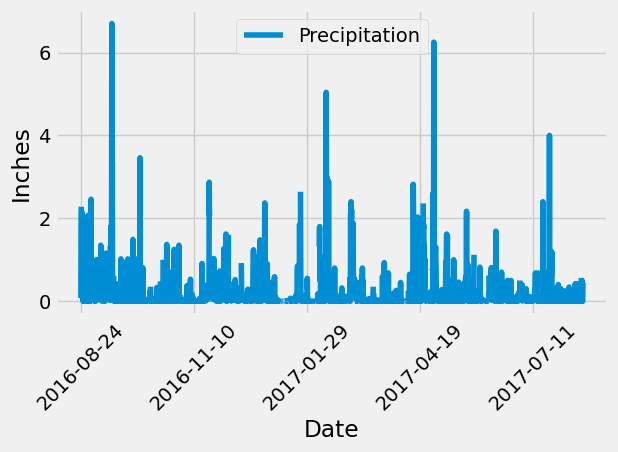

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago =  most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True) #Set the index for the new data frame

# Sort the dataframe by date
df_sorted = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df_sorted.plot(y='precipitation', use_index=True, legend=False)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe().to_frame()
summary_statistics

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()
total_stations
#print("Total number of stations:", total_stations)

9

In [32]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
# List the stations and their counts in descending order.
sorted_stations = [(station, count) for station, count in active_stations]
print(sorted_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = sorted_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

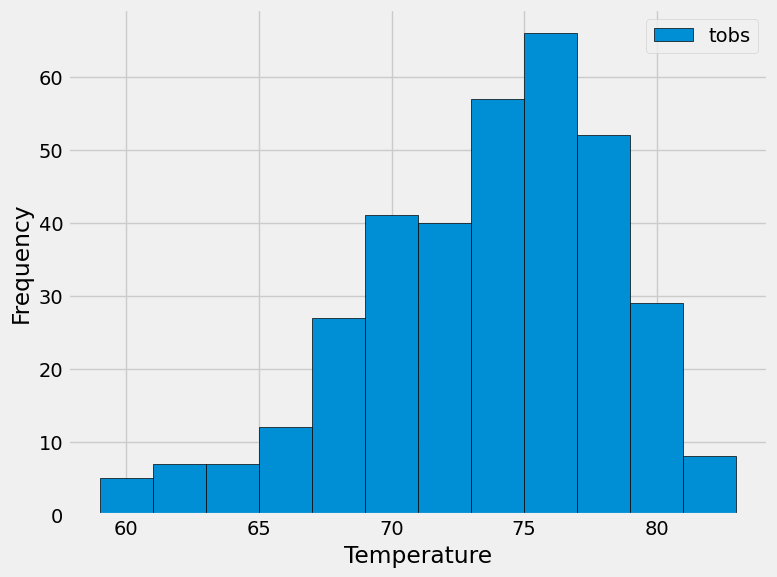

In [37]:
# Using the most active station id

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = [temp[0] for temp in temperature_data]
temperatures
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=1)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()


# Close Session

In [38]:
# Close Session
session.close()